# Part 1 – Sillhouhette score



----
----

#### **Data Preprocessing Before Loading**

The first step is to clean the data for EDTA QC.
- Any samples with missing data were excluded. 
- Data were normalized using three reference genes: 
- Data were checked for outliers, which were excluded (no outliers are allowed in the training data). 


----
----

#### **Module Import**

In [274]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.svm import SVC
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from scipy.stats import gaussian_kde



In [275]:
# ── Setup paths relative to project root ──
cwd = Path().cwd()
ROOT = cwd
while not (ROOT / "README.md").exists():
    ROOT = ROOT.parent

DATA_DIR = ROOT / "data"
NB_OUTPUT = ROOT / "notebooks" / "outputs_from_notebooks"


# Create folders if needed
DATA_DIR.mkdir(parents=True, exist_ok=True)
NB_OUTPUT.mkdir(parents=True, exist_ok=True)

# Paths to data
UNKNOWN2_PATH = DATA_DIR / "unknown2_markers.csv"
UNKNOWN2_FNR10_PATH = DATA_DIR / "unknown2_FNR10.csv"
UNKNOWN2_RIN_PATH = DATA_DIR / "unknown2_RIN.csv"


print("ROOT:", ROOT)
print("DEV_DATA_PATH:", UNKNOWN2_PATH, "Exists?", UNKNOWN2_PATH.exists())
print("DEV_DATA_PATH:", UNKNOWN2_PATH, "Exists?", UNKNOWN2_PATH.exists())
print("DEV_DATA_PATH:", UNKNOWN2_PATH, "Exists?", UNKNOWN2_PATH.exists())


ROOT: c:\Users\UserPhD\OneDrive - Univerzita Karlova\spidia ČLÁNEK 2 obnoveno 2022\aplikace_predikce
DEV_DATA_PATH: c:\Users\UserPhD\OneDrive - Univerzita Karlova\spidia ČLÁNEK 2 obnoveno 2022\aplikace_predikce\data\unknown2_markers.csv Exists? True
DEV_DATA_PATH: c:\Users\UserPhD\OneDrive - Univerzita Karlova\spidia ČLÁNEK 2 obnoveno 2022\aplikace_predikce\data\unknown2_markers.csv Exists? True
DEV_DATA_PATH: c:\Users\UserPhD\OneDrive - Univerzita Karlova\spidia ČLÁNEK 2 obnoveno 2022\aplikace_predikce\data\unknown2_markers.csv Exists? True


----
----

#### **Importing and Preprocessing Training and Validation data**

In this section, we will work with the development dataset (165 samples) measured by qPCR. 
It represents the *development set*, obtained by removing 23 predefined hold-out samples.  
This dataset will be split into training (80%) and validation (20%) subsets (donor-disjoint). 

#### Task 1: Importing data

In [276]:

unknown2_markers_df = pd.read_csv(UNKNOWN2_PATH, index_col=0)

In [277]:
unknown2_markers_df.head()

,LIG3,RPA3,CDK7,DDB2,ERCC5,ERCC1,NBN,ATR,CHEK1,CHEK2,TP53,treatment
FLUIDIGM,,,,,,,,,,,,
75,-0.145,-1.475,-0.113,-0.883,-0.368,-0.558,-0.594,-0.146,-1.801,-1.166,-0.031,0
78,0.725,-0.840,-0.769,-0.834,0.875,-0.772,-0.836,0.201,-0.623,-0.307,0.178,0
80,1.209,-0.736,0.008,-0.984,0.223,1.062,-0.696,1.129,0.603,-1.552,1.219,0
82,0.237,-0.691,-0.373,-0.601,-0.090,0.524,-0.859,0.388,0.814,-0.937,0.305,0
83,1.052,-0.868,-0.696,-0.520,0.878,0.027,0.169,0.032,-0.361,-0.847,-0.945,0


In [278]:
print(unknown2_markers_df.shape)
print(unknown2_markers_df.columns.tolist())
print(unknown2_markers_df.isna().sum())

(72, 12)
['LIG3', 'RPA3', 'CDK7', 'DDB2', 'ERCC5', 'ERCC1', 'NBN', 'ATR', 'CHEK1', 'CHEK2', 'TP53', 'treatment']
LIG3         0
RPA3         0
CDK7         0
DDB2         0
ERCC5        0
ERCC1        0
NBN          0
ATR          0
CHEK1        0
CHEK2        0
TP53         0
treatment    0
dtype: int64


FNR10 filtering removed a subset of samples while preserving both classes.
This led to a more compact within-class structure and increased inter-class separation, reflected by higher silhouette scores.

In [279]:
unknown2_FNR10_df = pd.read_csv(UNKNOWN2_FNR10_PATH, index_col=0)

In [280]:
print(unknown2_FNR10_df.shape)
print(unknown2_FNR10_df.columns.tolist())
print(unknown2_FNR10_df.isna().sum())

(48, 12)
['LIG3', 'RPA3', 'CDK7', 'DDB2', 'ERCC5', 'ERCC1', 'NBN', 'ATR', 'CHEK1', 'CHEK2', 'TP53', 'treatment']
LIG3         0
RPA3         0
CDK7         0
DDB2         0
ERCC5        0
ERCC1        0
NBN          0
ATR          0
CHEK1        0
CHEK2        0
TP53         0
treatment    0
dtype: int64


In [281]:
unknown2_RIN_df = pd.read_csv(UNKNOWN2_RIN_PATH, index_col=0)

In [282]:
print(unknown2_RIN_df.shape)
print(unknown2_RIN_df.columns.tolist())
print(unknown2_RIN_df.isna().sum())

(62, 12)
['LIG3', 'RPA3', 'CDK7', 'DDB2', 'ERCC5', 'ERCC1', 'NBN', 'ATR', 'CHEK1', 'CHEK2', 'TP53', 'treatment']
LIG3         0
RPA3         0
CDK7         0
DDB2         0
ERCC5        0
ERCC1        0
NBN          0
ATR          0
CHEK1        0
CHEK2        0
TP53         0
treatment    0
dtype: int64


----

#### Task 2: Splitting into dependent and independent variables

In [283]:
marker_cols = [
    "LIG3", "RPA3", "CDK7", "DDB2", "ERCC5",
    "ERCC1", "NBN", "ATR", "CHEK1", "CHEK2", "TP53"
]

In [284]:
X = unknown2_markers_df[marker_cols].values
y = unknown2_markers_df["treatment"].values
print("Class distribution, all samples:", np.unique(y, return_counts=True))

Class distribution, all samples: (array([0, 1]), array([35, 37]))


In [285]:
X_fnr10 = unknown2_FNR10_df[marker_cols].values
y_fnr10 = unknown2_FNR10_df["treatment"].values
print("Class distribution, FNR 10/% samples:", np.unique(y_fnr10, return_counts=True))

Class distribution, FNR 10/% samples: (array([0, 1]), array([23, 25]))


In [286]:
X_RIN = unknown2_RIN_df[marker_cols].values
y_RIN = unknown2_RIN_df["treatment"].values
print("Class distribution, with exclusion of samples with RIN <= 8.5 :", np.unique(y_RIN, return_counts=True))

Class distribution, with exclusion of samples with RIN <= 8.5 : (array([0, 1]), array([31, 31]))


----

#### Task 4: Scaling

In [287]:
# Initialization of StandardScaler
scaler = StandardScaler()

In [288]:
# Fit scaler on full dataset (reference scaling)
scaler.fit(X)

StandardScaler()

In [289]:
# Scale full dataset
X_scaled_full = scaler.transform(X)
print("Scaled full dataset shape:", X_scaled_full.shape)

Scaled full dataset shape: (72, 11)


In [290]:
# Scale FNR10-filtered dataset using the same scaler
X_scaled_fnr10 = scaler.transform(X_fnr10)
print("Scaled FNR10 dataset shape:", X_scaled_fnr10.shape)

Scaled FNR10 dataset shape: (48, 11)


In [291]:
# Scale RIN-filtered dataset using the same scaler
X_scaled_RIN = scaler.transform(X_RIN)
print("Scaled RIN dataset shape:", X_scaled_RIN.shape)

Scaled RIN dataset shape: (62, 11)


----

#### Task 5: Silhouete score without pca, full space

To quantitatively assess group separation, silhouette score was calculated in the standardized multidimensional feature space using Euclidean distance. This metric evaluates how similar each sample is to its own group compared to the opposite group and provides a threshold-independent measure of separation. PCA was used exclusively for two-dimensional visualization and not for computation of silhouette score.

Silhouette score quantifies how well samples are separated
based on distances in the original feature space.
It is computed on standardized marker expression values, not on PCA coordinates, which are used only for visualization.

Silhouette score ranges from −1 to +1, with higher values indicating better separation between predefined groups.

Values ≥ ~0.5 indicate strong separation with minimal overlap between groups.

Values between ~0.25 and 0.5 indicate moderate separation with partial overlap, typical for complex biological data.

Values close to 0 indicate weak or no meaningful group separation.

Negative values suggest incorrect group assignment or strong overlap between groups.

In [292]:
sil_all = silhouette_score(X_scaled_full, y)
sil_RIN = silhouette_score(X_scaled_RIN, y_RIN)
sil_fnr10 = silhouette_score(X_scaled_fnr10, y_fnr10)

print("Silhouette score - full feature space")
print(f"Full dataset:  {sil_all:.3f}")
print(f"RIN dataset: {sil_RIN:.3f}")
print(f"FNR10 dataset: {sil_fnr10:.3f}")

Silhouette score - full feature space
Full dataset:  0.286
RIN dataset: 0.339
FNR10 dataset: 0.359


----

#### Task 6: PCA transformation with 2 principal components

This silhouette score is calculated in the 2D PCA space.
It is provided for illustrative purposes only and should not be used as the primary quantitative metric of group separation.

In [293]:
# Fit PCA on 2 components
pca2 = PCA(n_components=2, random_state=42)

X_scaled_pca2_full  = pca2.fit_transform(X_scaled_full)

print("PCA-transformed full dataset shape:", X_scaled_pca2_full.shape)
print("Explained variance (full):", pca2.explained_variance_ratio_)
print("Total explained variance (full):", pca2.explained_variance_ratio_.sum())

PCA-transformed full dataset shape: (72, 2)
Explained variance (full): [0.46327211 0.20423821]
Total explained variance (full): 0.6675103244190805


In [294]:
# PCA for FNR10 dataset
pca2_fnr10 = PCA(n_components=2, random_state=42)

# Fit PCA on scaled FNR10 dataset and transform
X_scaled_pca2_fnr10 = pca2_fnr10.fit_transform(X_scaled_fnr10)

print("PCA-transformed FNR10 dataset shape:", X_scaled_pca2_fnr10.shape)
print("Explained variance (FNR10):", pca2_fnr10.explained_variance_ratio_)
print("Total explained variance (FNR10):", pca2_fnr10.explained_variance_ratio_.sum())

PCA-transformed FNR10 dataset shape: (48, 2)
Explained variance (FNR10): [0.52602069 0.23164455]
Total explained variance (FNR10): 0.7576652404054929


In [295]:
# PCA for FNR10 dataset
pca2_RIN = PCA(n_components=2, random_state=42)

# Fit PCA on scaled FNR10 dataset and transform
X_scaled_pca2_RIN = pca2_RIN.fit_transform(X_scaled_RIN)

print("PCA-transformed RIN dataset shape:", X_scaled_pca2_RIN.shape)
print("Explained variance (RIN):", pca2_RIN.explained_variance_ratio_)
print("Total explained variance (RIN):", pca2_RIN.explained_variance_ratio_.sum())

PCA-transformed RIN dataset shape: (62, 2)
Explained variance (RIN): [0.47198456 0.19196729]
Total explained variance (RIN): 0.6639518510467455


----

#### Task 57: Silhouete score - 2D space

In [296]:

# Silhouette score on 2D PCA space (full dataset)
sil_pca2_full = silhouette_score(X_scaled_pca2_full, y)

print(f"Silhouette score (FULL dataset, PCA2): {sil_pca2_full:.3f}")


Silhouette score (FULL dataset, PCA2): 0.412


In [297]:
# Silhouette score on 2D PCA space (FNR10-filtered dataset)
sil_pca2_fnr10 = silhouette_score(X_scaled_pca2_fnr10, y_fnr10)

print(f"Silhouette score (FNR10 dataset, PCA2): {sil_pca2_fnr10:.3f}")


Silhouette score (FNR10 dataset, PCA2): 0.512


In [298]:
# Silhouette score on 2D PCA space (RIN-filtered dataset)
sil_pca2_RIN = silhouette_score(X_scaled_pca2_RIN, y_RIN)

print(f"Silhouette score (RIN dataset, PCA2): {sil_pca2_RIN:.3f}")

Silhouette score (RIN dataset, PCA2): 0.493


----

#### Task 8: PCA scatter plot for all data

In [299]:
COLORS = {
    "tumor": "#FFBF00",
    "healthy": "#2CB2BA"
    }

In [300]:
silhouettes = [
    sil_pca2_full,
    sil_pca2_fnr10,
    sil_pca2_RIN
]

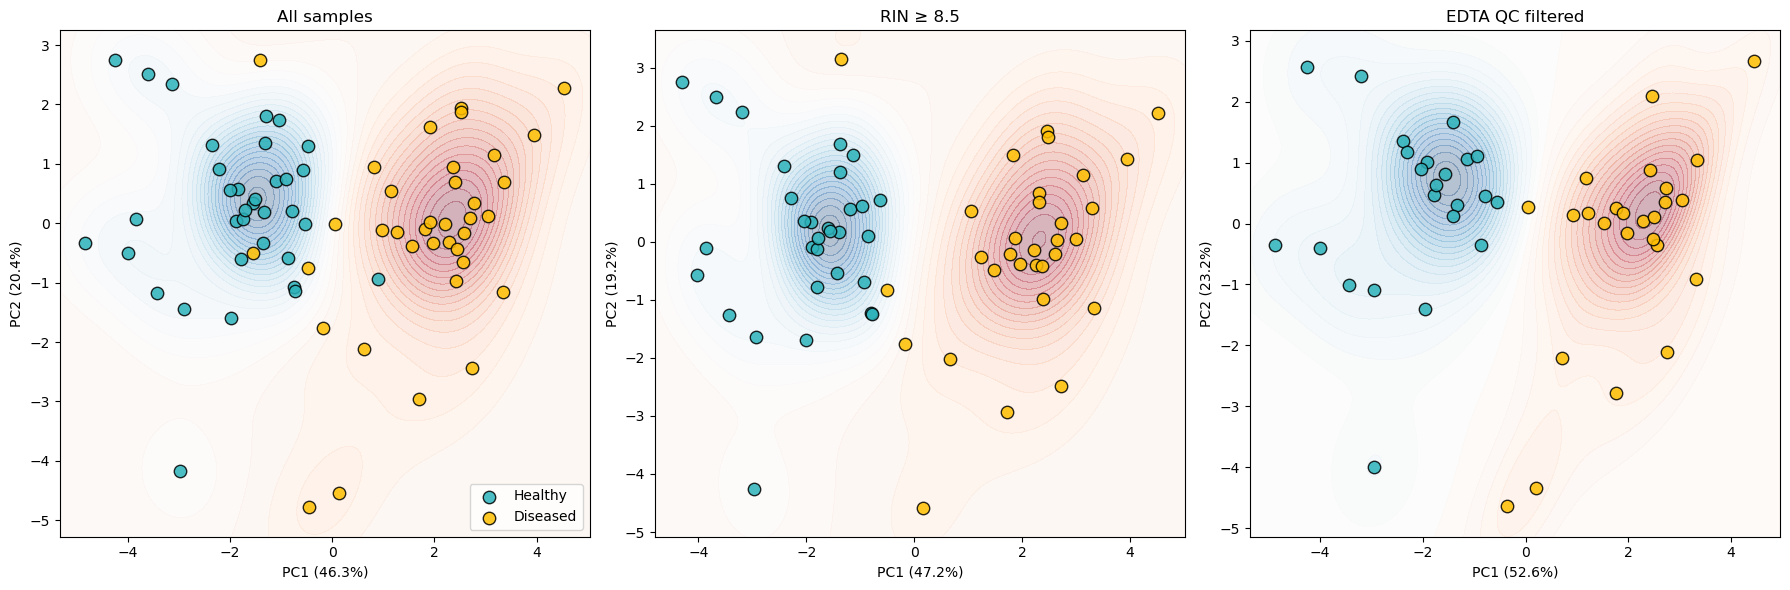

In [306]:

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

datasets = [
    (X_scaled_pca2_full,  y,       pca2,       "All samples"),
    (X_scaled_pca2_RIN,   y_RIN,   pca2_RIN,   "RIN ≥ 8.5"),
    (X_scaled_pca2_fnr10, y_fnr10, pca2_fnr10, "EDTA QC filtered"),
]

for ax, (X_pca, y_lab, pca_obj, title) in zip(axes, datasets):

    # ---------- KDE BACKGROUND ----------
    x_min, x_max = X_pca[:, 0].min() - 0.5, X_pca[:, 0].max() + 0.5
    y_min, y_max = X_pca[:, 1].min() - 0.5, X_pca[:, 1].max() + 0.5

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )
    grid = np.vstack([xx.ravel(), yy.ravel()])

    kde_healthy  = gaussian_kde(X_pca[y_lab == 0].T)
    kde_diseased = gaussian_kde(X_pca[y_lab == 1].T)

    Z = kde_diseased(grid) - kde_healthy(grid)
    Z = Z.reshape(xx.shape)

    ax.contourf(
        xx, yy, Z,
        levels=40,
        cmap="RdBu_r",
        alpha=0.30
    )

    # ---------- POINTS ----------
    for label, name, color in [
        (0, "Healthy",  COLORS["healthy"]),
        (1, "Diseased", COLORS["tumor"])
    ]:
        idx = y_lab == label
        ax.scatter(
            X_pca[idx, 0],
            X_pca[idx, 1],
            label=name,
            color=color,
            edgecolors="k",
            s=80,
            alpha=0.85,
            zorder=2
        )

    ax.set_xlabel(f"PC1 ({pca_obj.explained_variance_ratio_[0]*100:.1f}%)")
    ax.set_ylabel(f"PC2 ({pca_obj.explained_variance_ratio_[1]*100:.1f}%)")
    ax.set_title(title)

axes[0].legend(loc="lower right")

plt.tight_layout()
plt.show()


mportantly, all patients included in this analysis achieved clinical remission, with the final sampling performed one year after therapeutic intervention. Expression-based quality control did not remove samples based on clinical outcome, but selectively excluded samples affected by EDTA-induced expression changes. After filtering, samples from patients in long-term remission consistently localized within the healthy expression space, whereas samples collected prior to surgery or shortly after intervention remained distinct, reflecting their biological state at the time of sampling. Without expression-based QC, a subset of samples would have been mispositioned relative to their clinical context, underscoring the risk of pre-analytical artifacts introducing biologically misleading signals.

Together, these results illustrate that when disease- or quality-associated markers are carefully selected and appropriate pre-analytical controls are applied, expression data can resolve biologically meaningful structure with high clarity.

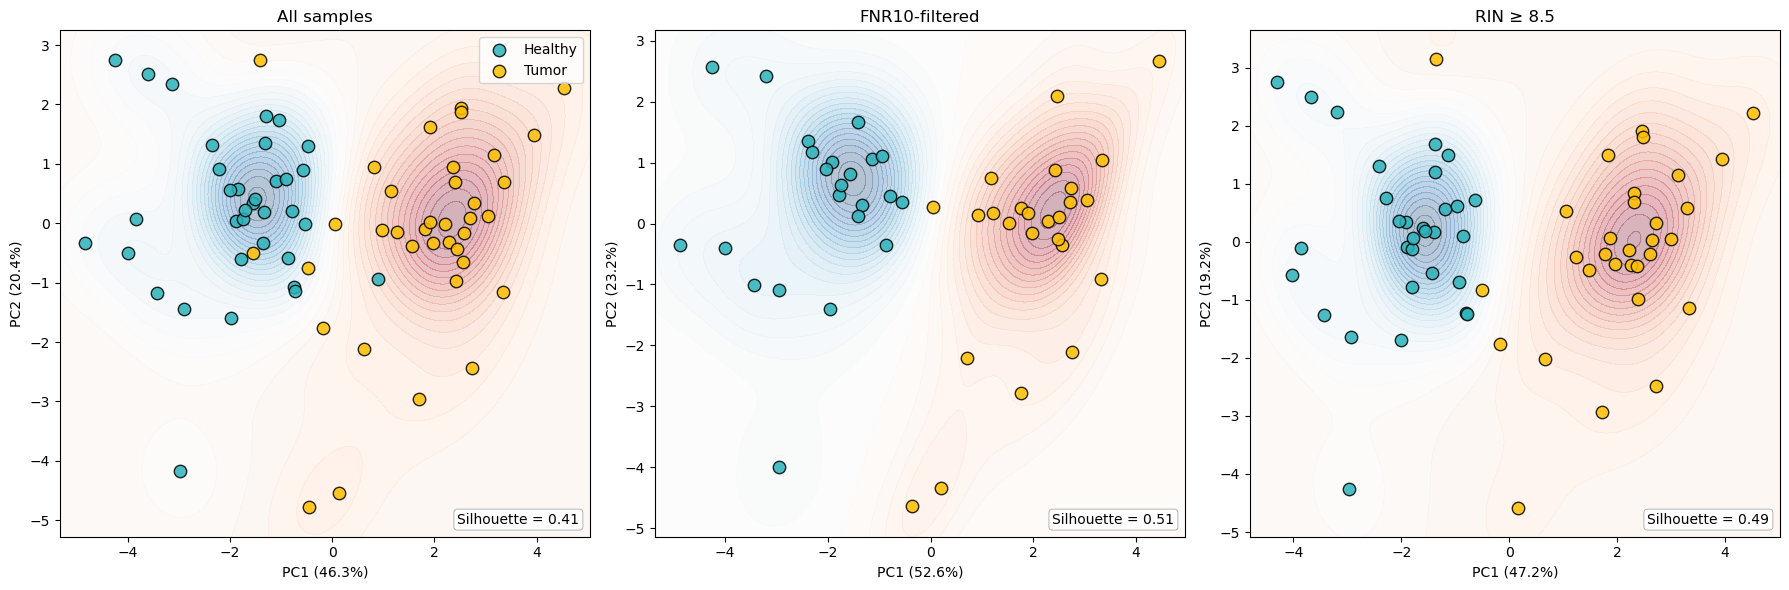

In [302]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

datasets = [
    (X_scaled_pca2_full,  y,       pca2,  "All samples"),
    (X_scaled_pca2_fnr10, y_fnr10, pca2_fnr10, "FNR10-filtered"),
    (X_scaled_pca2_RIN,   y_RIN,   pca2_RIN,   "RIN ≥ 8.5"),
]

for ax, (X_pca, y_lab, pca_obj, title), sil in zip(axes, datasets, silhouettes):

    x_min, x_max = X_pca[:, 0].min() - 0.5, X_pca[:, 0].max() + 0.5
    y_min, y_max = X_pca[:, 1].min() - 0.5, X_pca[:, 1].max() + 0.5

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )
    grid = np.vstack([xx.ravel(), yy.ravel()])

    kde_healthy = gaussian_kde(X_pca[y_lab == 0].T)
    kde_tumor   = gaussian_kde(X_pca[y_lab == 1].T)

    Z = kde_tumor(grid) - kde_healthy(grid)
    Z = Z.reshape(xx.shape)

    ax.contourf(
        xx, yy, Z,
        levels=40,
        cmap="RdBu_r",
        alpha=0.30
    )

    for label, name, color in [
        (0, "Healthy", COLORS["healthy"]),
        (1, "Tumor",   COLORS["tumor"])
    ]:
        idx = y_lab == label
        ax.scatter(
            X_pca[idx, 0],
            X_pca[idx, 1],
            label=name,
            color=color,
            edgecolors="k",
            s=80,
            alpha=0.85
        )

    ax.text(
        0.98, 0.02,
        f"Silhouette = {sil:.2f}",
        transform=ax.transAxes,
        ha="right",
        va="bottom",
        fontsize=10,
        bbox=dict(
            facecolor="white",
            edgecolor="#AAA9A9",
            linewidth=0.6,
            boxstyle="round,pad=0.25"
        )
    )


    ax.set_xlabel(f"PC1 ({pca_obj.explained_variance_ratio_[0]*100:.1f}%)")
    ax.set_ylabel(f"PC2 ({pca_obj.explained_variance_ratio_[1]*100:.1f}%)")
    ax.set_title(title)

axes[0].legend()

plt.tight_layout()
plt.show()

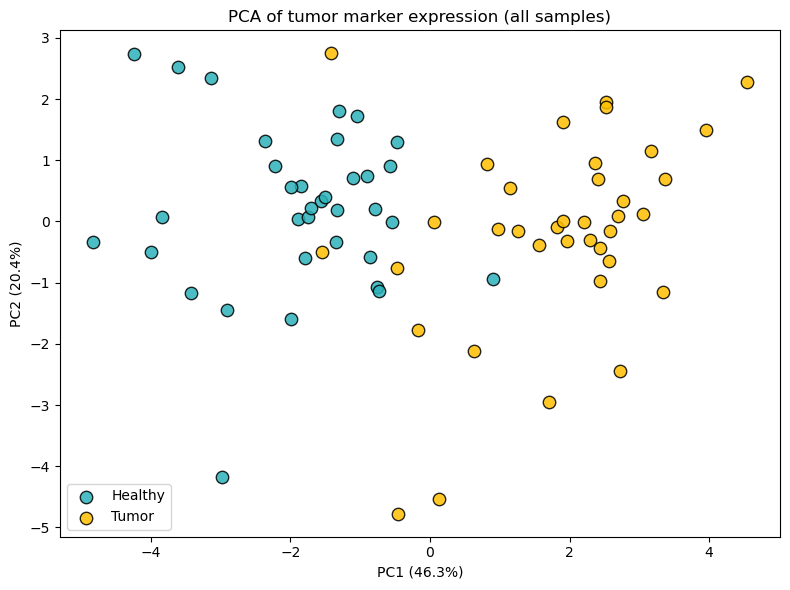

In [303]:
plt.figure(figsize=(8,6))

for label, name, color in [
    (0, "Healthy", COLORS["healthy"]),
    (1, "Tumor",   COLORS["tumor"])
]:
    idx = y == label
    plt.scatter(
        X_scaled_pca2_full[idx, 0],
        X_scaled_pca2_full[idx, 1],
        label=name,
        color=color,
        edgecolors="k",
        s=80,
        alpha=0.85
    )

plt.xlabel(f"PC1 ({pca2.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca2.explained_variance_ratio_[1]*100:.1f}%)")
plt.legend()
plt.title("PCA of tumor marker expression (all samples)")

plt.tight_layout()
plt.show()

----
----

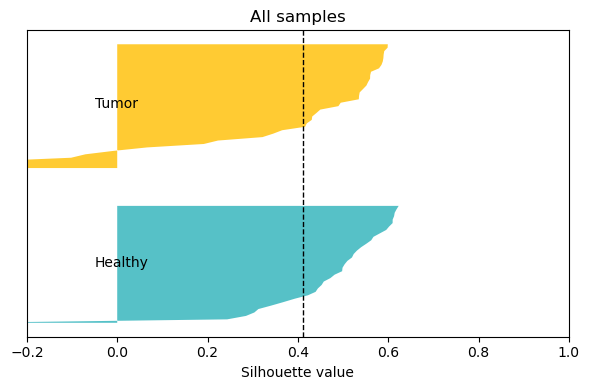

In [304]:

sil_vals = silhouette_samples(X_scaled_pca2_full, y)
sil_avg  = sil_pca2_full

fig, ax = plt.subplots(figsize=(6, 4))
y_lower = 10

for label, name, color in [
    (0, "Healthy", COLORS["healthy"]),
    (1, "Tumor",   COLORS["tumor"])
]:
    vals = sil_vals[y == label]
    vals.sort()

    y_upper = y_lower + len(vals)

    ax.fill_betweenx(
        np.arange(y_lower, y_upper),
        0, vals,
        facecolor=color,
        alpha=0.8
    )

    ax.text(-0.05, (y_lower + y_upper) / 2, name, va="center")
    y_lower = y_upper + 10

ax.axvline(sil_avg, color="black", linestyle="--", lw=1)

ax.set_title("All samples")
ax.set_xlabel("Silhouette value")
ax.set_yticks([])
ax.set_xlim([-0.2, 1])

plt.tight_layout()
plt.show()


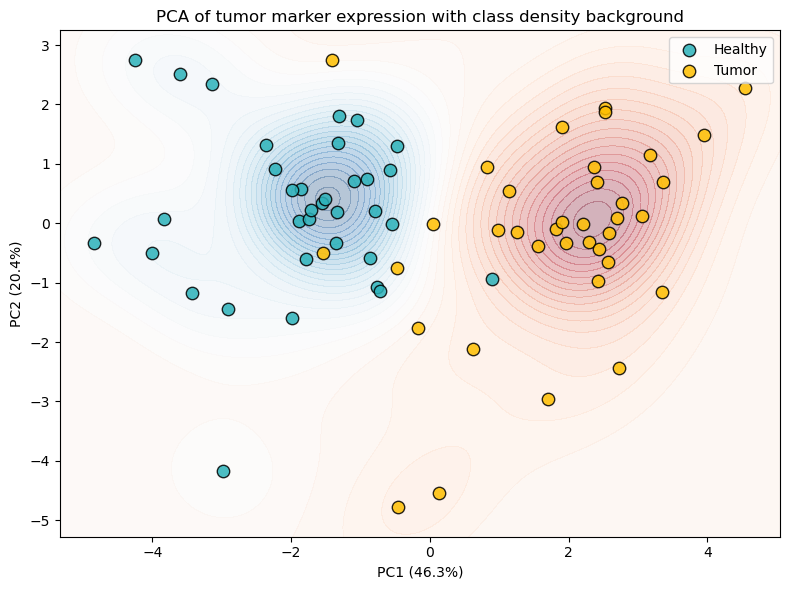

In [305]:

# 1) rozsah PCA prostoru
x_min, x_max = X_scaled_pca2_full[:, 0].min() - 0.5, X_scaled_pca2_full[:, 0].max() + 0.5
y_min, y_max = X_scaled_pca2_full[:, 1].min() - 0.5, X_scaled_pca2_full[:, 1].max() + 0.5

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)
grid = np.vstack([xx.ravel(), yy.ravel()])

# 2) KDE pro obě třídy
kde_healthy = gaussian_kde(X_scaled_pca2_full[y == 0].T)
kde_tumor   = gaussian_kde(X_scaled_pca2_full[y == 1].T)

# 3) rozdíl hustot (tumor − healthy)
Z = kde_tumor(grid) - kde_healthy(grid)
Z = Z.reshape(xx.shape)

# 4) vykreslení pozadí
plt.figure(figsize=(8, 6))

plt.contourf(
    xx, yy, Z,
    levels=40,
    cmap="RdBu_r",
    alpha=0.30   # DŮLEŽITÉ: pozadí zůstane jemné
)

# 5) body (stejné jako ve tvém původním grafu)
for label, name, color in [
    (0, "Healthy", COLORS["healthy"]),
    (1, "Tumor",   COLORS["tumor"])
]:
    idx = y == label
    plt.scatter(
        X_scaled_pca2_full[idx, 0],
        X_scaled_pca2_full[idx, 1],
        label=name,
        color=color,
        edgecolors="k",
        s=80,
        alpha=0.85,
        zorder=2
    )

plt.xlabel(f"PC1 ({pca2.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca2.explained_variance_ratio_[1]*100:.1f}%)")
plt.legend()
plt.title("PCA of tumor marker expression with class density background")

plt.tight_layout()
plt.show()
